# Authors & References:

This notebook is created by:
- Joshua Adrian Cahyono
- Clayton Fernalo
- Bryan Artista Kiely

### Dataset Reference:

Guo, S., Lin, Y., Feng, N., Song, C., & Wan, H. (2019). Attention Based Spatial-Temporal Graph Convolutional Networks for Traffic Flow Forecasting. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 922-929. https://doi.org/10.1609/aaai.v33i01.3301922

### Additional Reference:

ChatGPT is used for debugging, clarification of concepts, and the writing of comments and descriptions. 

<a id="contents"></a>
# Table of Content
1. [Problem Introduction](#section-1)
2. [Import Libraries & Initialize Plots](#section-2)
3. [Data Formatting](#section-3)
4. [Data Visualization & EDA](#section-4)
5. [Data Preparation](#section-5)
6. [Train Model](#section-6)
7. [Evaluate Prediction](#section-7)
8. [Conclusion](#section-8)

<a id="section-1"></a>
# Problem Introduction

We have found an interesting traffic dataset `PEMS-08 Dataset`, which contains the traffic data in San Bernardino from July to August in 2016. There are 170 locations with detectors recording every 5 minute intervals of traffic information. The dataset includes 3 features: `flow`, `occupy`, `speed`. The details of the features are as the following:

- The flow variable in the PEMS08 dataset represents the number of vehicles that pass through the loop detector per time interval (5 minutes in this case). It is measured in vehicles per 5-minute interval.

- The occupancy variable represents the proportion of time during the time interval (5 minutes) that the detector was occupied by a vehicle. It is measured as a percentage.

- The speed variable represents the average speed of the vehicles passing through the loop detector during the time interval (5 minutes). It is measured in miles per hour (mph).
 
From this, we thought of an interesting question: what if we create an model that can predict and properly rank the locations with the most traffic? We believe that this predictive task could potentially help the police in choosing the best locations to patrol given a particular time. To simply the problem, we believe that `occupy` encaptures the estimated traffic at a certain time, so we will be using `occupy` as our target variable.

Formally, we formulated the following problem statement:
For $N$ prediction of the `occupy` variable and $K$ locations, make a predictive model to minimize $\sum_{t=0}^{N-1} \rho_t$, where $\rho_t$ is defined as the [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the prediction values and the actual values.

The Spearman correlation coefficient is a measure of the strength and direction of the monotonic relationship between two variables. It is not calculated based on the absolute value, but rather it only considers the relativity of the ranks of the variables. This is perfect for our task, since we want to focus on patrol location optimization.

Our current strategy is to first focus on minimizing `RMSE` on predicting the actual values of the target variable `occupy`, and to simply use the rank of the values. For this, we will train an `LSTM` model and use the moving average of previous `occupy` values as the baseline.

<a id="section-2"></a>
# Import Libraries & Initialize Plots

As always, we will first import all the libraries necessary for this notebook to run. We put all the imports at the top to make it easier to check the dependencies.

In [1]:
# Common libraries for data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import load # use to load an npz file
from scipy.signal import periodogram # use to graph a periodogram to get seasonality analysis
from sklearn.preprocessing import MinMaxScaler # use to normalize the data features

# keras library to create NN models
from keras.models import Sequential
from keras.layers import LSTM, Dense

# libraries for the metrics we will use (RMSE and Spearman)
from keras.metrics import RootMeanSquaredError
import scipy.stats as stats

In addition, we changed the notebook default plotting settings to make the graph prettier.

In [2]:
# Set plot settings
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5

<a id="section-3"></a>
# Data Formatting

Interestingly, the data is in the format of npz. npz is a file format used by the NumPy library to store arrays and metadata in a compressed format. We will first convert it to pandas dataframe, since we are more familiar with it.

In [3]:
data = load('/kaggle/input/traffic-flow/pems08.npz')

In [4]:
lst = data.files
print(data[lst[0]].shape)
print(data[lst[0]])

(17856, 170, 3)
[[[1.330e+02 6.030e-02 6.580e+01]
  [2.100e+02 5.890e-02 6.960e+01]
  [1.240e+02 3.580e-02 6.580e+01]
  ...
  [7.400e+01 2.131e-01 6.530e+01]
  [9.400e+01 2.260e-02 6.800e+01]
  [6.000e+00 3.100e-03 6.500e+01]]

 [[1.140e+02 5.320e-02 6.690e+01]
  [1.850e+02 5.500e-02 6.850e+01]
  [1.190e+02 3.390e-02 6.500e+01]
  ...
  [7.300e+01 1.469e-01 3.720e+01]
  [8.400e+01 1.890e-02 6.870e+01]
  [4.000e+00 1.800e-03 6.500e+01]]

 [[1.400e+02 6.220e-02 6.680e+01]
  [1.710e+02 4.660e-02 6.990e+01]
  [1.070e+02 3.360e-02 6.380e+01]
  ...
  [7.000e+01 5.860e-02 3.400e+01]
  [8.200e+01 2.200e-02 6.700e+01]
  [4.000e+00 2.100e-03 6.490e+01]]

 ...

 [[1.200e+02 5.810e-02 6.330e+01]
  [1.760e+02 5.290e-02 6.680e+01]
  [1.190e+02 5.180e-02 5.610e+01]
  ...
  [4.700e+01 1.551e-01 3.220e+01]
  [9.100e+01 2.290e-02 6.640e+01]
  [3.000e+00 1.400e-03 6.530e+01]]

 [[1.020e+02 5.790e-02 6.140e+01]
  [1.650e+02 4.920e-02 6.720e+01]
  [1.330e+02 5.070e-02 5.890e+01]
  ...
  [9.700e+01 1.265e-01

The file gives a numpy array with dimensions (17856, 170, 3), which are in the form of (timesteps, location, features). For the 3 features, the order is `flow`,`occupy`,`speed`.

In [5]:
traffic_data = data[lst[0]]
data_dict = []
# loop for every timestep and every location and add as a single row
for timestep in range(traffic_data.shape[0]):
    for location in range(traffic_data.shape[1]):
        data_dict.append({
            "timestep" : timestep+1,
            "location" : location,
            "flow"     : traffic_data[timestep][location][0],
            "occupy"   : traffic_data[timestep][location][1],
            "speed"    : traffic_data[timestep][location][2]
        })

We changed it into a list of dictionary. Each row represents a single timestep in a single location.

In [6]:
df = pd.DataFrame(data_dict)
df.to_csv("traffic.csv", index=False)

Finally, we save it into a csv file called `traffic.csv`. So, if you already have the file `traffic.csv`, you won't need to run the code above.

<a id="section-4"></a>
# Data Visualization & EDA

Now it is time for Data Visualization and Exploratory Data Analysis. Here, we will see through the data and clean and apply feature engineering when necessary.

In [7]:
traffic = pd.read_csv("/kaggle/working/traffic.csv")
print(len(traffic))
traffic.head()

3035520


,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


The data consist of $17856 \cdot 170 = 3035520$ rows. That is a lot of rows! We will have to handle that later, but for now, let us look into the data.

In [8]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035520 entries, 0 to 3035519
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   timestep  int64  
 1   location  int64  
 2   flow      float64
 3   occupy    float64
 4   speed     float64
dtypes: float64(3), int64(2)
memory usage: 115.8 MB


All of the data seem to be either integer or float, nothing out of the ordinarily here. `flow`, `occupy` and `speed` are numerical and continuous data.

In [9]:
traffic.count()

timestep    3035520
location    3035520
flow        3035520
occupy      3035520
speed       3035520
dtype: int64

In [10]:
traffic.isna().sum()

timestep    0
location    0
flow        0
occupy      0
speed       0
dtype: int64

Also nothing surprising here, and fortunately the data has no null values, so we don't need to impute any values.

In [11]:
traffic.describe()

,timestep,location,flow,occupy,speed
count,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06
mean,8.928500e+03,8.450000e+01,2.306807e+02,6.507109e-02,6.376300e+01
std,5.154584e+03,4.907393e+01,1.462170e+02,4.590215e-02,6.652010e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,4.464750e+03,4.200000e+01,1.100000e+02,3.570000e-02,6.260000e+01
50%,8.928500e+03,8.450000e+01,2.150000e+02,6.010000e-02,6.490000e+01
75%,1.339225e+04,1.270000e+02,3.340000e+02,8.390000e-02,6.740000e+01
max,1.785600e+04,1.690000e+02,1.147000e+03,8.955000e-01,8.230000e+01


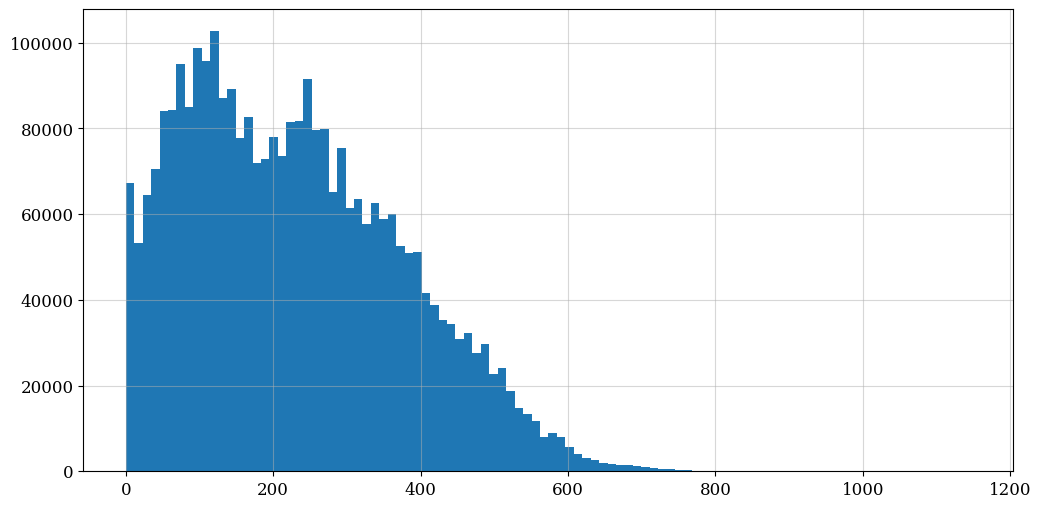

In [12]:
traffic['flow'].hist(bins=100);

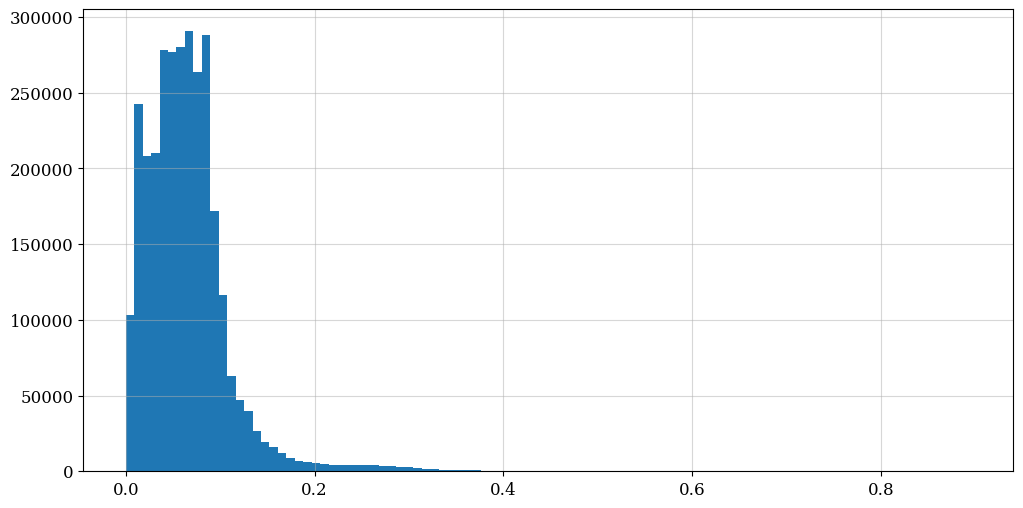

In [13]:
traffic['occupy'].hist(bins=100);

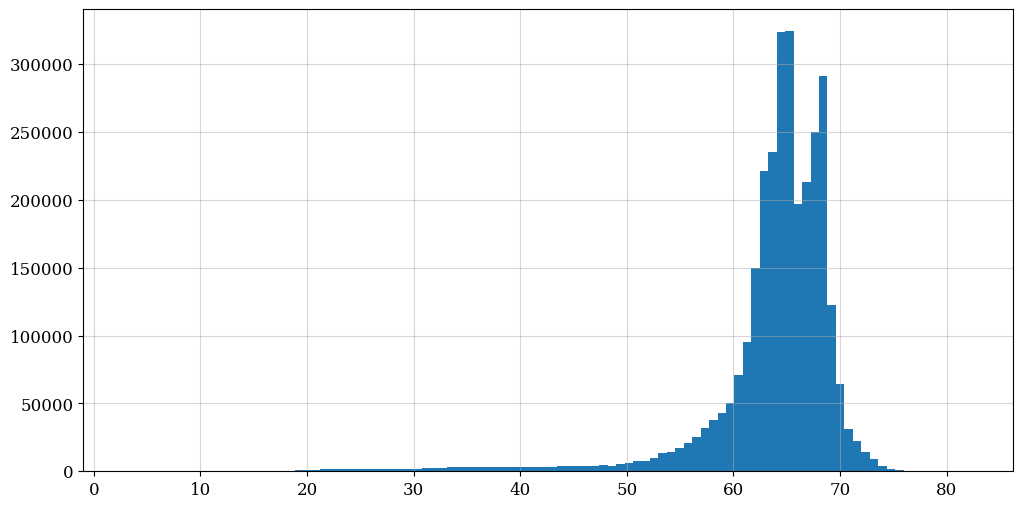

In [14]:
traffic['speed'].hist(bins=100);

Looking at the distribution of `flow`, `occupy` and `speed`, it looks like they are spread out nicely and roughly follows a nice (a bit skewed) normal distribution. However, one thing to note is that the order of magnitude of the values are quite different, so we should normalize and scale the data later.

Now, we would like to explore the data further. For this, we will choose a single random location.

In [15]:
location_0 = traffic[traffic["location"]==50].reset_index()
location_0.head()

,index,timestep,location,flow,occupy,speed
0,50,1,50,76.0,0.0262,69.5
1,220,2,50,81.0,0.0255,68.8
2,390,3,50,80.0,0.0243,69.0
3,560,4,50,76.0,0.0255,68.4
4,730,5,50,70.0,0.0224,68.1


<AxesSubplot:>

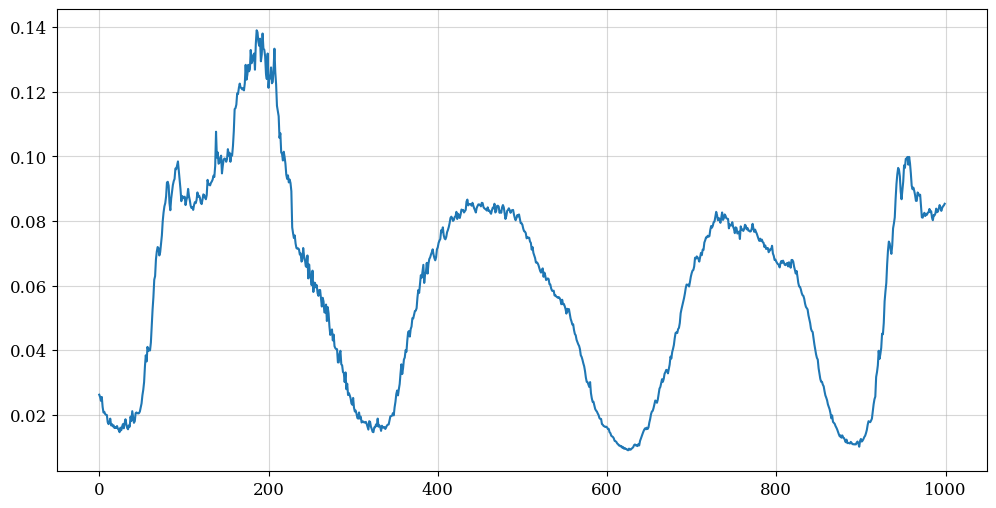

In [16]:
location_0["occupy"][:1000].plot()

<AxesSubplot:>

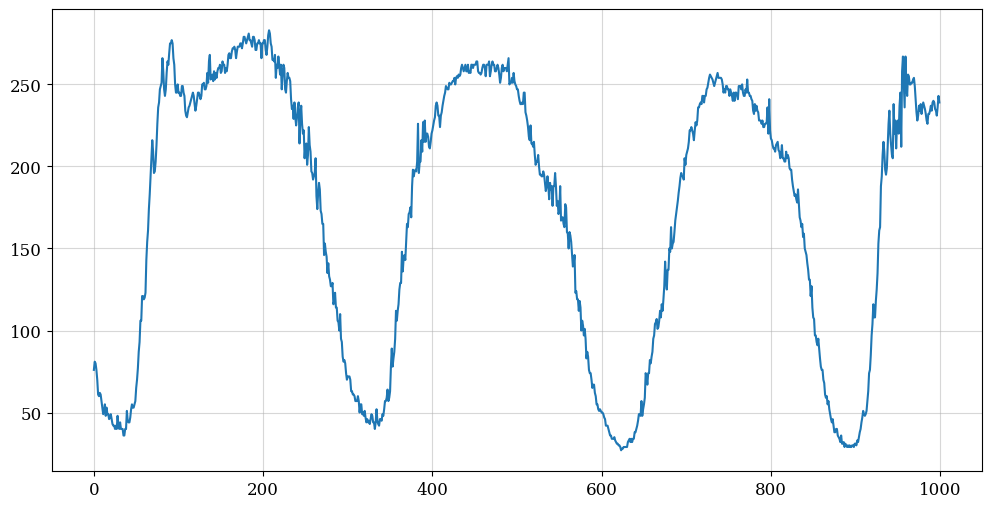

In [17]:
location_0["flow"][:1000].plot()

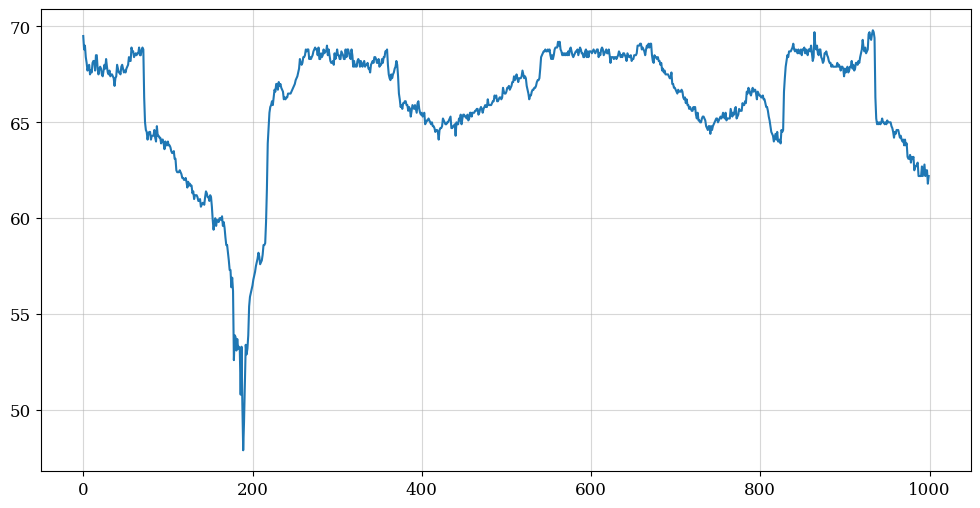

In [18]:
location_0["speed"][:1000].plot();

We limit the plot to the first 1000 values since there are too many timesteps and the plot will be hard to look and analyze. From the plot above (and checking some other random locations), there seem to be a strong seasonality on `flow` and more importantly `occupy` , which is out target variable. 

Of course in any time series prediction, lag features are used as the main features. Specifically, $k$ lag features means that we use the last $k$ values to predict the next value. So, it is a good measure to check the correlation of present $(t_n)$ and future $(t_{n+1})$ values

In [19]:
COR_STEP = 1
pres = traffic[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = traffic[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.674039,-0.296332,0.535235,0.450192,-0.235030
occupy,0.674039,1.000000,-0.752040,0.445282,0.477379,-0.303858
speed,-0.296332,-0.752040,1.000000,-0.228266,-0.275180,0.233537
flow_future,0.535235,0.445282,-0.228266,1.000000,0.674040,-0.296331
occupy_future,0.450192,0.477379,-0.275180,0.674040,1.000000,-0.752040
speed_future,-0.235030,-0.303858,0.233537,-0.296331,-0.752040,1.000000


From this (and some other locations we check), we can see that the correlation of all the variables to occupy is moderately high. (It might not look that high, but considering that we can use multiple steps of lag features, it is a pretty good correlation.) In addition, it is also nice to see that the correlation of `flow` and `speed` to `occupy` is also high, which suggests that the variables might be linearly correlated and could be used to predict each other.

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

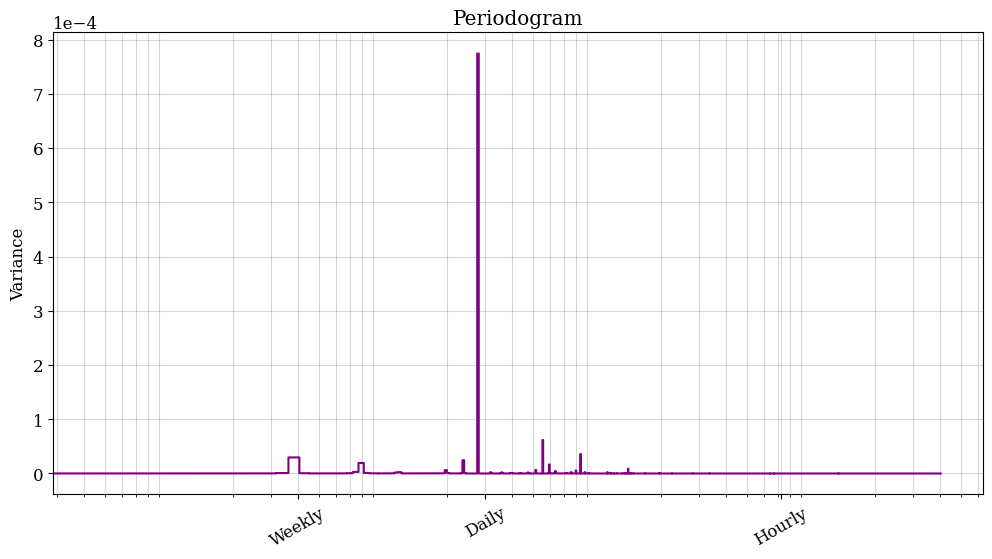

In [20]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Plots the periodogram of a time series.

    Args:
        ts (pd.Series): A time series.
        detrend (str): Detrending method for the time series.
        ax (matplotlib.axes.Axes): The axes on which to plot.

    Returns:
        ax (matplotlib.axes.Axes): The axes on which the periodogram is plotted.
    """
    fs = pd.Timedelta(weeks=4) / pd.Timedelta(minutes=5)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
        
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([4, 30, 30*24])
    ax.set_xticklabels(
        [
            "Weekly",
            "Daily",
            "Hourly"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(location_0["occupy"])

Here, we graph a [periodogram](https://en.wikipedia.org/wiki/Periodogram) to test the seasonality of the `occupy` variable. The periodogram shows the strength of the frequencies present in the time series, and can be used to identify the dominant frequencies or periodicities in the data. From the graph above, it suggests that there seem to be a pattern in the occupy variable daily, which makes sense, since many people work and travel on a fixed schedule. (for example busy hours after work will have higher traffic) For this reason, we will add an `hour` feature on prediction.

As said earlier, the number of rows in this is pretty large (and when we tried add >10 lag features, the memory limit exceeded >8gb). So, we will instead be working on hourly timesteps instead of 5 minutes interval. The data within an hour (12 5-minute timesteps) will be averaged.

In [21]:
location_0["hour"] = ((location_0["timestep"] - 1) // 12)
grouped = location_0.groupby("hour").mean().reset_index()
grouped.head()

,hour,index,timestep,location,flow,occupy,speed
0,0,985.0,6.5,50.0,65.500000,0.021700,68.191667
1,1,3025.0,18.5,50.0,48.166667,0.016567,67.900000
2,2,5065.0,30.5,50.0,41.166667,0.016350,67.691667
3,3,7105.0,42.5,50.0,46.666667,0.019350,67.591667
4,4,9145.0,54.5,50.0,89.750000,0.031800,68.141667


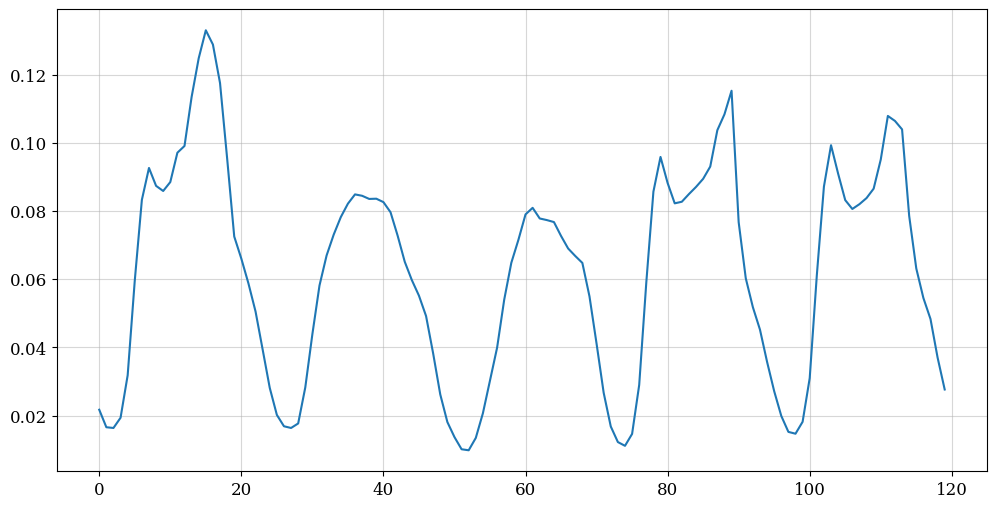

In [22]:
grouped["occupy"][:24*5].plot();

In [23]:
COR_STEP = 1
pres = grouped[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = grouped[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.966271,-0.719419,0.940515,0.891626,-0.670349
occupy,0.966271,1.000000,-0.839598,0.930323,0.931733,-0.770824
speed,-0.719419,-0.839598,1.000000,-0.725025,-0.810388,0.881795
flow_future,0.940515,0.930323,-0.725025,1.000000,0.966259,-0.719411
occupy_future,0.891626,0.931733,-0.810388,0.966259,1.000000,-0.839607
speed_future,-0.670349,-0.770824,0.881795,-0.719411,-0.839607,1.000000


After merging the timesteps, we get a higher correlation with future values, which is nice.

<a id="section-5"></a>
# Data Preparation

Now that we are done with the EDA, it is time to prepare our data for prediction. We add the features we found useful from the EDA. We also normalize and split our data to train and test datasets.

In [24]:
# creating 3-dimensional array for [timestep, timeframe, features]
def create_dataset(location, WINDOW_SIZE):
    
    # mask a certain location
    location_current = traffic[traffic["location"]==location].reset_index()
    
    # group to hour and average 12 (5-minute) timesteps
    location_current["hour"] = ((location_current["timestep"] - 1) // 12)
    grouped = location_current.groupby("hour").mean().reset_index()
    
    # add hour features as mod 24 cycle (0...23)
    grouped['hour'] %= 24
    one_hot = pd.get_dummies(grouped['hour'])
    one_hot = one_hot.add_prefix('hour_')
    
    # merge all the features together to get a total of 27 features
    hour_grouped = pd.concat([grouped[["occupy", "flow", "speed"]], one_hot], axis=1)
    hour_grouped = np.array(hour_grouped)
    
    X, Y = [], []
    
    # add lag features (in reverse time order)
    for i in range(len(hour_grouped) - WINDOW_SIZE):
        X.append(hour_grouped[i:(i + WINDOW_SIZE)][::-1]) # reverse the order
        Y.append(hour_grouped[i + WINDOW_SIZE, 0]) # index 0 is occupy
    
    return X,Y # returns (timestep, timeframe, features) and (target)

We make a `create_dataset` function to make all the features that we need for the prediction (hour features and lag features as multiple dimensions). Each lag step (lag steps total of WINDOW_SIZE) will be included to X in the second dimension (in reverse order). We format the array X as dimension (timestep, timeframe, features) and Y as dimension (target).

In [25]:
# creating 4-th dimension for the locations
X, Y = [], []

for location in range(170):
    a,b = create_dataset(location, WINDOW_SIZE=24)
    X.append(a)
    Y.append(b)
    
X = np.moveaxis(X,0,-1)
Y = np.moveaxis(Y,0,-1)

print(X.shape)
print(Y.shape)

(1464, 24, 27, 170)
(1464, 170)


Finally here, we merge all the locations together to get X `(timestep, timeframe, features, location)` and Y `(timestep, location)`.

In [26]:
TRAIN_SIZE = 0.8
TEST_SIZE  = 0.2

train_size = int(len(X) * TRAIN_SIZE)
test_size  = int(len(X) * TEST_SIZE)

train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1171, 24, 27, 170)
(1171, 170)
(293, 24, 27, 170)
(293, 170)


Here, we split the data into train and test with `train : test` ratio of `0.8 : 0.2`. In a time series analysis, we don't usually use random splitting because it wont make sense to predict data in gaps, so we split the first 80% as train while the last 20% is used as test set. 

In [27]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X.reshape(train_X.shape[0] * train_X.shape[1], -1)) \
                   .reshape(train_X.shape[0], train_X.shape[1], -1)
test_X = scaler_X.transform(test_X.reshape(test_X.shape[0] * test_X.shape[1], -1)) \
                   .reshape(test_X.shape[0], test_X.shape[1], -1)
train_Y = scaler_Y.fit_transform(train_Y)
test_Y = scaler_Y.transform(test_Y)

Then, we apply a `MinMaxScaler` to scale both X and Y features to the range (0,1). (Note that we need to use a different scaler for X and Y. Also, the good practice is to not fit using test since we assume that it is a fresh data and we have no information about it, so we only using train split to fit the scaler.

In [28]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(1171, 24, 4590)
(293, 24, 4590)
(1171, 170)
(293, 170)


Note that the shape changed a bit for X. I reshaped it so that the dimensions are `(timestep, timeframe, features*location)`. (we merged the locations together so that the final dimensions have features for every 170 locations.)

<a id="section-6"></a>
# Model Training

Finally, the exciting part! We get to see our prediction model in action. We will use an LSTM layer as the input layer while we will output a vector of 170 values, each one to predict the value of `occupy` of each location. 

The reason we used an LSTM layer is because the LSTM is built to remember information from earlier timesteps and gain information from their relation.

We will use `MSE` for the loss and `RMSE` as the metric. (metric will not be used for backpropagation and only serve to look at how well the prediction is at that iteration)

Also, we use `ReLu` since our task is a regression task.

In [29]:
model = Sequential([
    LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False),
    Dense(256, activation='linear'),
    Dense(170, activation='linear'),
])

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               4963328   
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 170)               43690     
                                                                 
Total params: 5,072,810
Trainable params: 5,072,810
Non-trainable params: 0
_________________________________________________________________


Once the model architecture is set, it is time to train the model. We can tune the hyperparemeters: epoch (the number of training iterations) and batch_size (the number of rows to include in a single forward and backpropagation). We will include validation split of 0.1 (by default it will take 10% of the last few rows and use it as validation data, which is not used for training but we can use it to evaluate on an unseen data for every given step).

In [31]:
# Train the model
model.fit(train_X, train_Y, epochs=100, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/100
33/33 - 8s - loss: 0.0307 - root_mean_squared_error: 0.1753 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176 - 8s/epoch - 238ms/step
Epoch 2/100
33/33 - 1s - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092 - 569ms/epoch - 17ms/step
Epoch 3/100
33/33 - 1s - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076 - 565ms/epoch - 17ms/step
Epoch 4/100
33/33 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081 - 573ms/epoch - 17ms/step
Epoch 5/100
33/33 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036 - 576ms/epoch - 17ms/step
Epoch 6/100
33/33 - 1s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083 - 565ms/epoch - 17ms/step
Epoch 7/100
33/33 - 1s - loss: 0.0081 - root_mean_squared_error: 0.0900 

<a id="section-7"></a>
# Evaluate Prediction

Now time to evaluate how good our model is. We add a moving average as the baseline. The reason we need a baseline is to see whether our RMSE score and Spearman score is actually good, not just due to random guessing.

In [32]:
def predict_and_calc_score(X, Y):
    # prediction of Y using the model
    pred = model.predict(X) 
    # moving average of Y
    window_size = 12
    moving_average = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=0, arr=Y)
    moving_average = np.concatenate((np.zeros((1, Y.shape[1])), moving_average), axis=0)[:Y.shape[0]]
    
    # scale it back to the original scale
    pred_scaled = scaler_Y.inverse_transform(pred)
    moving_average_scaled = scaler_Y.inverse_transform(moving_average)
    Y_scaled = scaler_Y.inverse_transform(Y)
    
    # calculate the RMSE
    baseline_RMSE = np.sqrt(np.mean((Y_scaled - moving_average_scaled) ** 2))
    model_RMSE = np.sqrt(np.mean((Y_scaled - pred_scaled) ** 2))
    
    return Y_scaled, pred_scaled, moving_average_scaled, model_RMSE, baseline_RMSE

def plot_prediction(actual, prediction, moving_average):
    # Plot the actual values
    plt.plot(actual, label="True value", linestyle='-', linewidth=1, marker='s', markersize=1)
    
    # Plot the moving average
    plt.plot(moving_average, label="Moving Average", linestyle='--', linewidth=1, marker='s', markersize=1)
    
    # Plot the predicted values
    plt.plot(prediction, label="Prediction", linestyle='--', linewidth=1, marker='o', markersize=1)
    
    # Set the title and axis labels
    plt.title('Prediction vs. True Value', fontsize=16)
    plt.xlabel('Hour Timesteps')
    plt.ylabel('Output Value')

    # Add a legend to the plot
    plt.legend(loc='upper left', fontsize=12)
    
    # Display the plot
    plt.show()

In [33]:
train_actual, train_prediction, train_moving_average, train_RMSE, baseline_RMSE = \
    predict_and_calc_score(train_X, train_Y)

print("Train Moving Average RMSE:", baseline_RMSE)
print("Train Prediction RMSE:", train_RMSE)

corr, pval = stats.spearmanr(train_actual, train_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(train_actual, train_prediction)
pred_spearman_corr = np.mean(corr)

print("Train Moving Average Spearman Correlation:", mov_spearman_corr)
print("Train Prediction Spearman Correlation:", pred_spearman_corr)

37/37 [==============================] - 1s 14ms/step
Train Moving Average RMSE: 0.02385027817581988
Train Prediction RMSE: 0.014234795101371276
Train Moving Average Spearman Correlation: 0.7151104327649883
Train Prediction Spearman Correlation: 0.7940323403212177


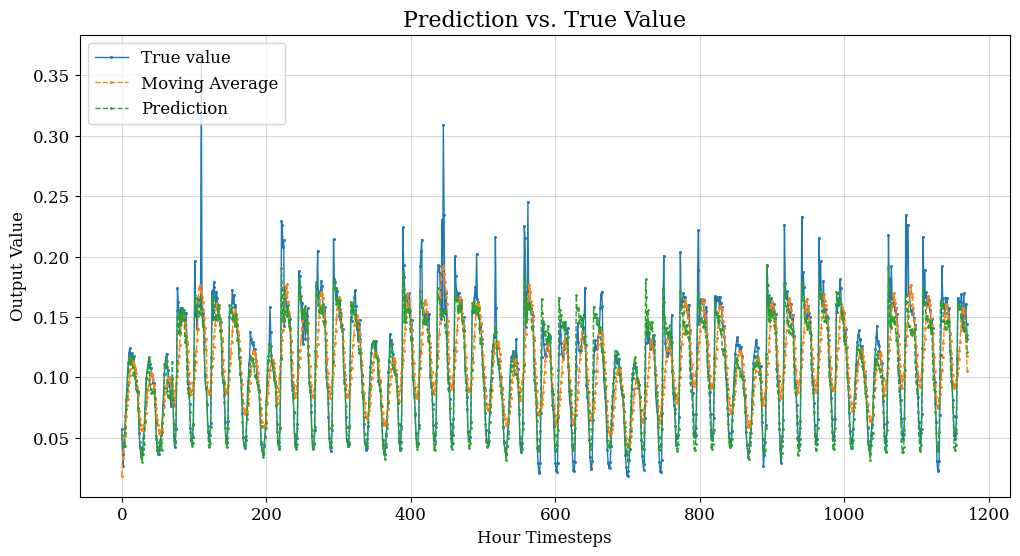

In [34]:
location = 0
plot_prediction(train_actual[:,location], train_prediction[:,location], train_moving_average[:,location])

The train RMSE and Spearman is good. It is better than the moving average and shows that the model is not underfitting. However, the true test lies on the test evaluation (since Neural Network models might overfit).

In [35]:
test_actual, test_prediction, test_moving_average, test_RMSE, baseline_RMSE = \
    predict_and_calc_score(test_X, test_Y)

print("Test Moving Average RMSE:", baseline_RMSE)
print("Test Prediction RMSE:", test_RMSE)

corr, pval = stats.spearmanr(test_actual, test_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(test_actual, test_prediction)
pred_spearman_corr = np.mean(corr)

print("Test Moving Average Spearman Correlation:", mov_spearman_corr)
print("Test Prediction Spearman Correlation:", pred_spearman_corr)

10/10 [==============================] - 0s 10ms/step
Test Moving Average RMSE: 0.026519227318993185
Test Prediction RMSE: 0.019899535139676832
Test Moving Average Spearman Correlation: 0.7208934552099153
Test Prediction Spearman Correlation: 0.8089676803155516


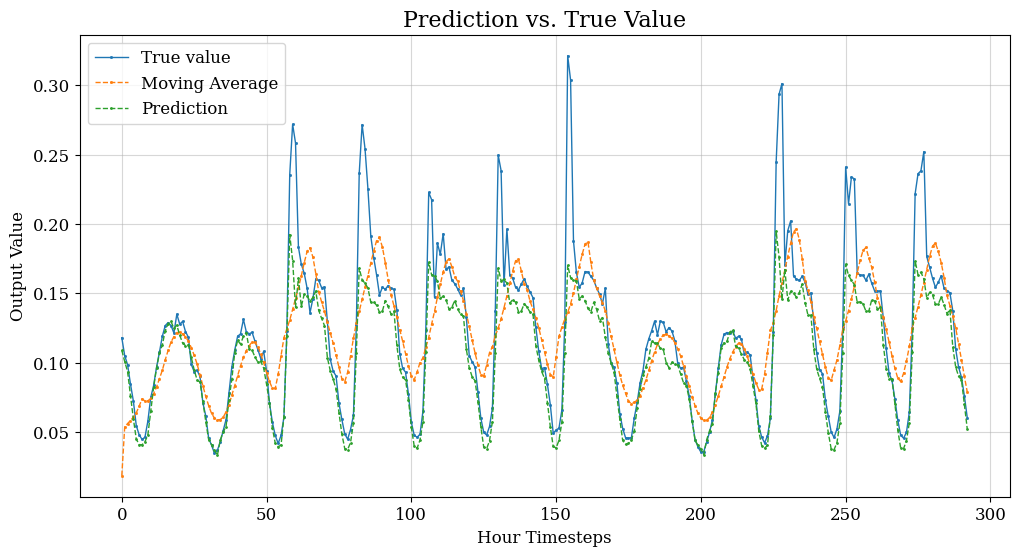

In [36]:
location = 0
plot_prediction(test_actual[:,location], test_prediction[:,location], test_moving_average[:,location])

The test RMSE and Spearman is also good! It is better than the moving average and shows that the model is not overfitting and can generalize well to new data.

In [37]:
model.save('LSTM_model')

In [38]:
!zip -r LSTM_Model.zip /kaggle/working/LSTM_model

  adding: kaggle/working/LSTM_model/ (stored 0%)
  adding: kaggle/working/LSTM_model/saved_model.pb (deflated 90%)
  adding: kaggle/working/LSTM_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/LSTM_model/variables/ (stored 0%)
  adding: kaggle/working/LSTM_model/variables/variables.data-00000-of-00001 (deflated 58%)
  adding: kaggle/working/LSTM_model/variables/variables.index (deflated 60%)
  adding: kaggle/working/LSTM_model/keras_metadata.pb (deflated 87%)
  adding: kaggle/working/LSTM_model/assets/ (stored 0%)


Finally, we can also save the model.

<a id="section-8"></a>
# Conclusion

To conclude, we have made a predictive model using an LSTM neural network. We included hour and lag features, and also carefully scale and split the data. In the end, our model was able to predict both the train and test data better than our baseline which is moving average of previous values. We believe that this model can be further optimized and tested to help solve one of the real world issues, which is traffic management.